<a class="anchor" id="0"></a>

# **ARIMA Model for Time Series Forecasting**

In this notebook, I will discuss **ARIMA Model for time series forecasting**. ARIMA model is used to forecast a time series using the series past values. In this notebokk, we build an **optimal ARIMA model**


# **1. Introduction to Time Series Forecasting** <a class="anchor" id="1"></a>


- A **Time Series** is defined as a series of data points recorded at different time intervals. The time order can be daily, monthly, or even yearly.

- Time Series forecasting is the process of using a statistical model to predict future values of a time series based on past results.

- Forecasting is the step where we want to predict the future values the series is going to take. Forecasting a time series is often of tremendous commercial value.

#### **Forecasting a time series can be broadly divided into two types.**

- If we use only the previous values of the time series to predict its future values, it is called **Univariate Time Series Forecasting.**

- If we use predictors other than the series (like exogenous variables) to forecast it is called **Multi Variate Time Series Forecasting.**

- This notebook focuses on a particular type of forecasting method called **ARIMA modeling.**



 So, **ARIMA**, short for **AutoRegressive Integrated Moving Average**, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.


- **ARIMA Models** are specified by three order parameters: (p, d, q), 

   where,

   - p is the order of the AR term

   - q is the order of the MA term

   - d is the number of differencing required to make the time series stationary


- **AR(p) Autoregression** – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.


- **I(d) Integration** – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.


- **MA(q) Moving Average** – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.

- Resources
  * https://medium.com/@siddhart.sharma/the-arma-arima-and-sarima-models-of-time-series-analysis-an-introduction-7244173de717
  * https://medium.com/analytics-vidhya/time-series-forecasting-and-analysis-arima-and-seasonal-arima-cacaf61ae863
  * https://medium.com/analytics-vidhya/a-thorough-introduction-to-arima-models-987a24e9ff71


### Here I have used a basic time series dataset to work on

**Steps I used in the notebook**
1. EDA
2. Check for Stationarity (ADF Test)
3. make sereise stationary
4. check for trend, seasonality, and residuals
5. find orders using acf and pacf
6. training the data
7. apply model
8. check for residuals
9. check for best orders using iterrools and rmse
10. reagain apply the model
11.  Evaluate the Model's Performance with RMSE
13. plots for fitted and actual
14. predictions and forecasting
    

### Import All Necesarry Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from statsmodels.tsa.stattools import adfuller
from numpy import log
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')


sns.set(style="whitegrid", color_codes=True, font_scale=1)
sns.set_palette('dark')

### Import Dataset

In [3]:

df = pd.read_excel('ARIMA_dataset.xlsx')

df.head()

date     value
0 1991-07-01  3.526591
1 1991-08-01  3.180891
2 1991-09-01  3.252221
3 1991-10-01  3.611003
4 1991-11-01  3.565869

### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB


In [5]:
df.isnull().sum()

date     0
value    0
dtype: int64

In [6]:
df.duplicated().sum()

0

Text(0.5, 1.0, 'Distribution of Data')

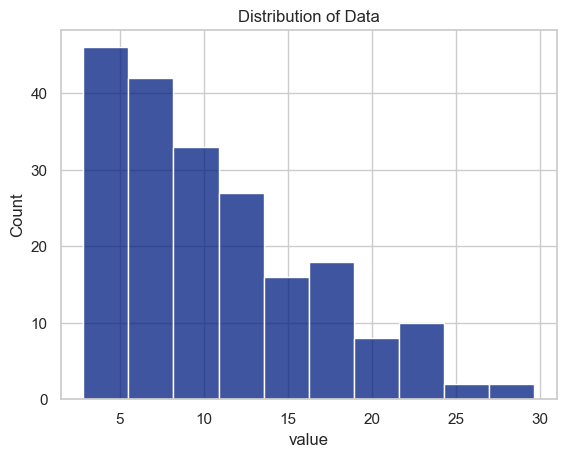

In [7]:
sns.histplot(df['value'])
plt.title('Distribution of Data')

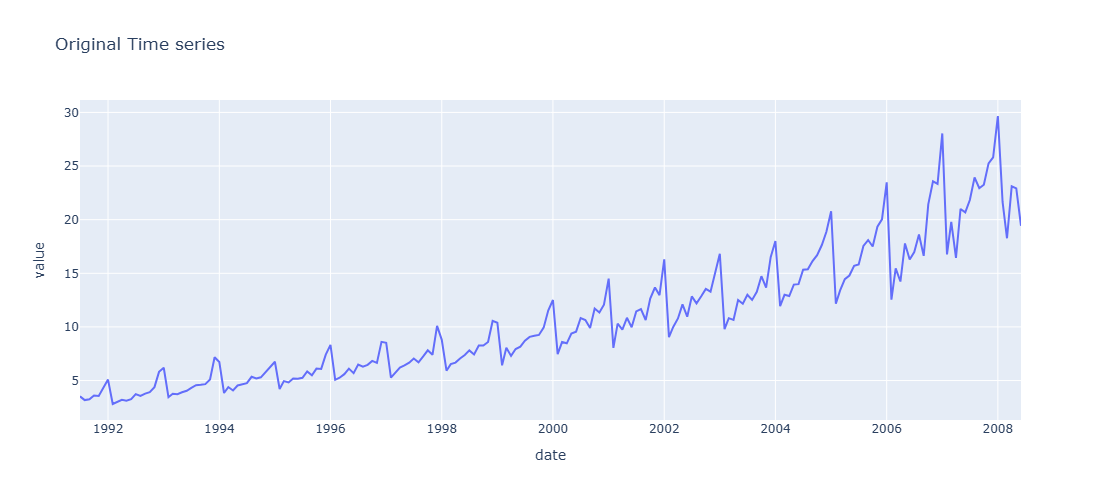

''

<Figure size 1300x700 with 0 Axes>

In [8]:
#ploting the time series original
plt.figure(figsize=(13,7))
fig=px.line(data_frame=df, x='date', y='value', title='Original Time series')

fig.update_layout(width=1000,height=500)
fig.show()
;

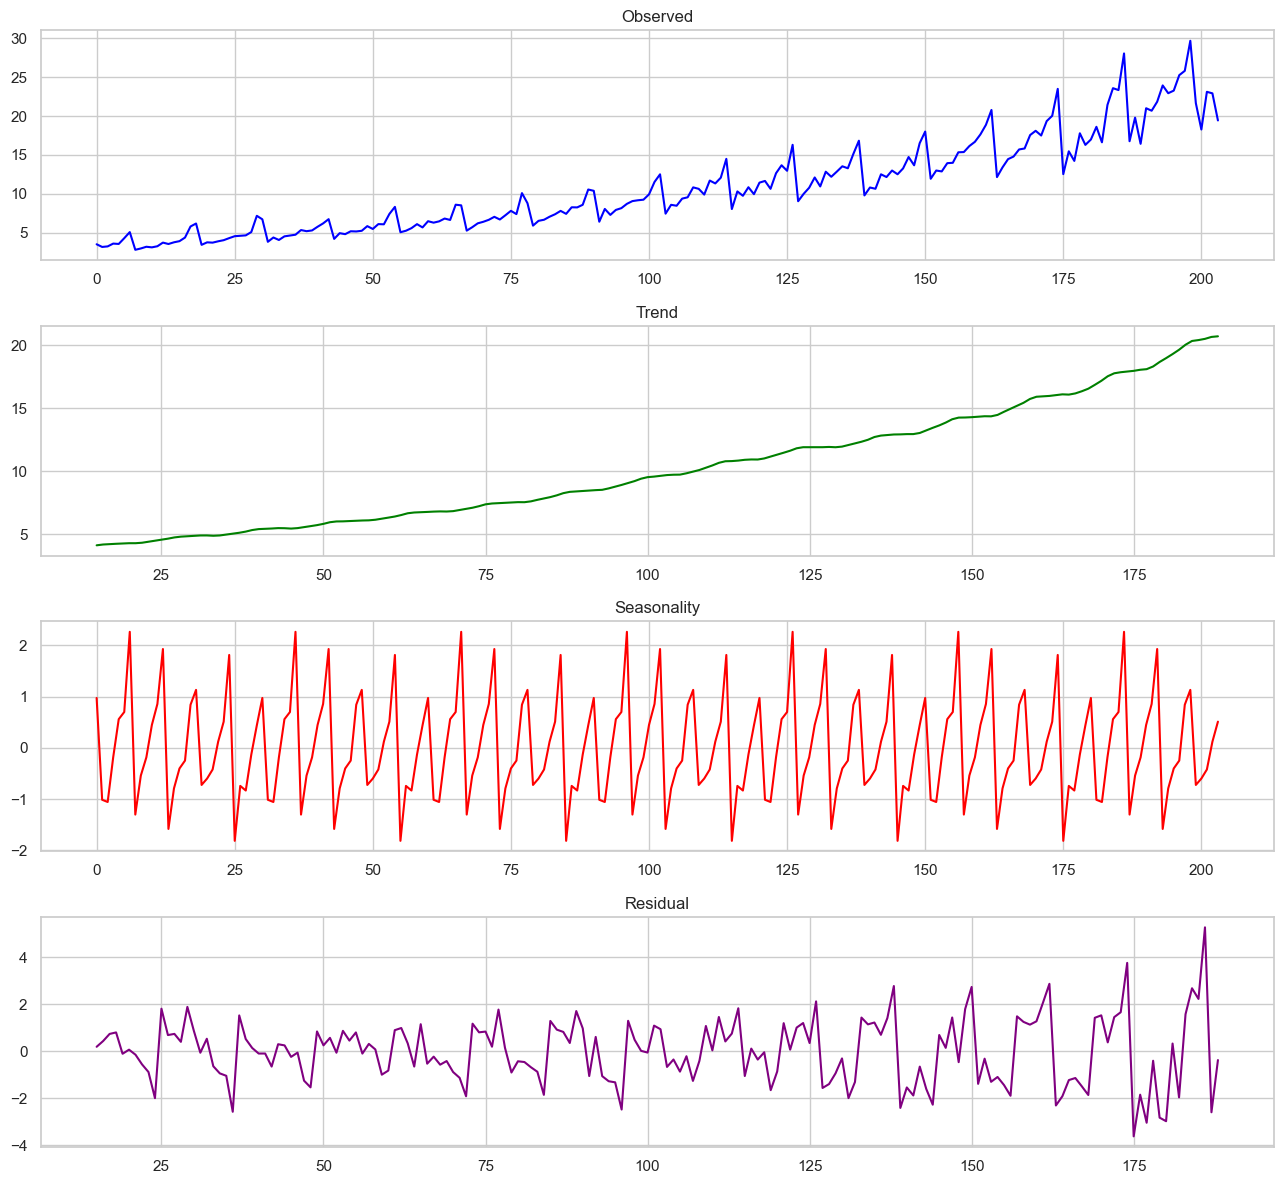

In [9]:

decomposition = sm.tsa.seasonal_decompose(df['value'], model='additive', period=30)
fig, axes = plt.subplots(4, 1, figsize=(13, 12))

decomposition.observed.plot(ax=axes[0], title="Observed", color='blue')
decomposition.trend.plot(ax=axes[1], title="Trend", color='green')
decomposition.seasonal.plot(ax=axes[2], title="Seasonality", color='red')
decomposition.resid.plot(ax=axes[3], title="Residual", color='purple')

plt.tight_layout()


- **As you can see from plot above, our time series has seasonal variation and a linear upward trend.**

### Check for Stationarity

In [10]:
result = adfuller(df.value.dropna(),autolag='AIC')
print('ADF Statistic: ', round(result[0],2))
print('p-value: ',round(result[1],2))

ADF Statistic:  3.15
p-value:  1.0


- Since p-value(1.00) is greater than the significance level(0.05), so time series is still Non-Stationary, let’s difference the series and see how the autocorrelation plot looks like.
- 
The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series isstilld stationary.

### Make series stationary - Applying diffirencing to make it Stationary

In [11]:
new_diff_1_data=df['value'].diff()
new_diff_1_data.head()

0         NaN
1   -0.345700
2    0.071330
3    0.358782
4   -0.045134
Name: value, dtype: float64

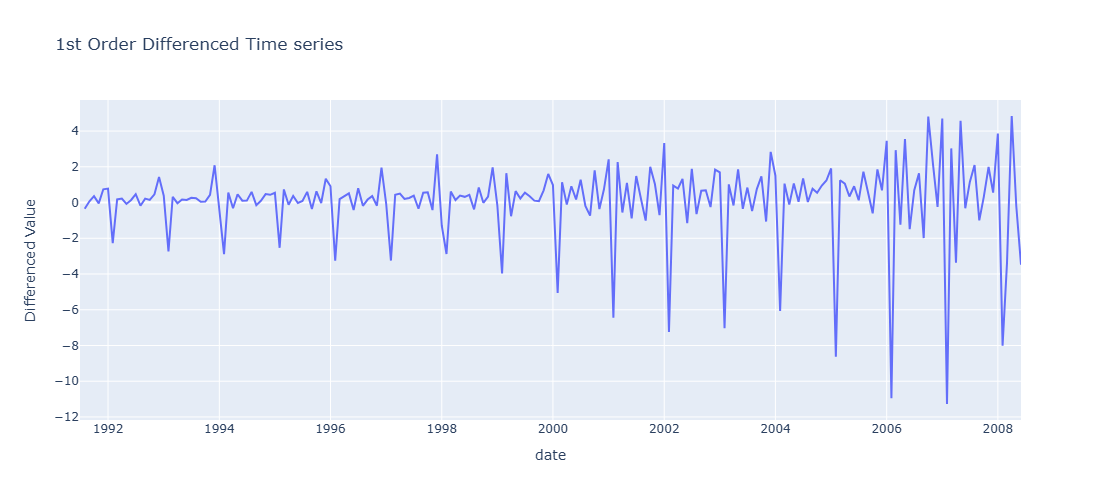

<Figure size 1000x500 with 0 Axes>

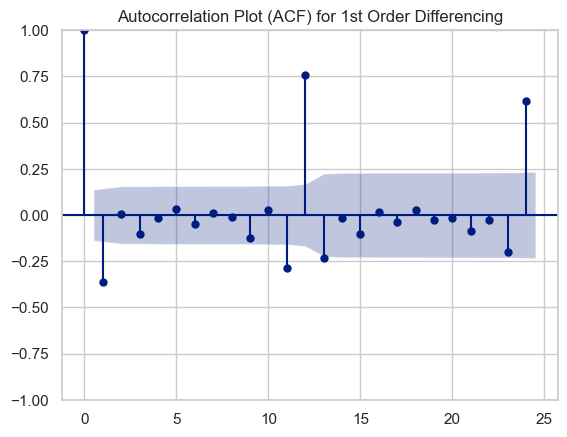

In [12]:
fig=px.line(x=df['date'],y=new_diff_1_data, title='1st Order Differenced Time series')

fig.update_layout(width=1000,height=500, xaxis_title='date',yaxis_title='Differenced Value')
fig.show()


plt.figure(figsize=(10, 5))
plot_acf(new_diff_1_data.dropna())
plt.title('Autocorrelation Plot (ACF) for 1st Order Differencing');



- The purpose of differencing is to make the time series stationary. But we should be careful to not over-difference the series. An over differenced series may still be stationary, which in turn will affect the model parameters.
- 
So we should determine the right order of differencing. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quiceries.

* If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag    1 autocorrelation itself is too negative, then the series is probably over-differenced.

* If we can’t really decide between two orders of differencing, then we go with the order that gives the least standard deviation in the differenced series.


### Now rechecking for Stationarity

In [13]:
result = adfuller(new_diff_1_data.dropna(),autolag='AIC')
print('ADF Statistic: ', round(result[0],2))
print('p-value: ',round(result[1],2))

ADF Statistic:  -2.5
p-value:  0.12


- Since p-value(1.00) is greater than the significance level(0.05), so time series is still Non-Stationary, let’s difference the series again and see how the autocorrelation plot looks like..

### Make series stationary - Reapplying diffirencing to make it Stationary

In [14]:
new_diff_2_data=df['value'].diff().diff()
new_diff_2_data.head()

0         NaN
1         NaN
2    0.417030
3    0.287452
4   -0.403916
Name: value, dtype: float64

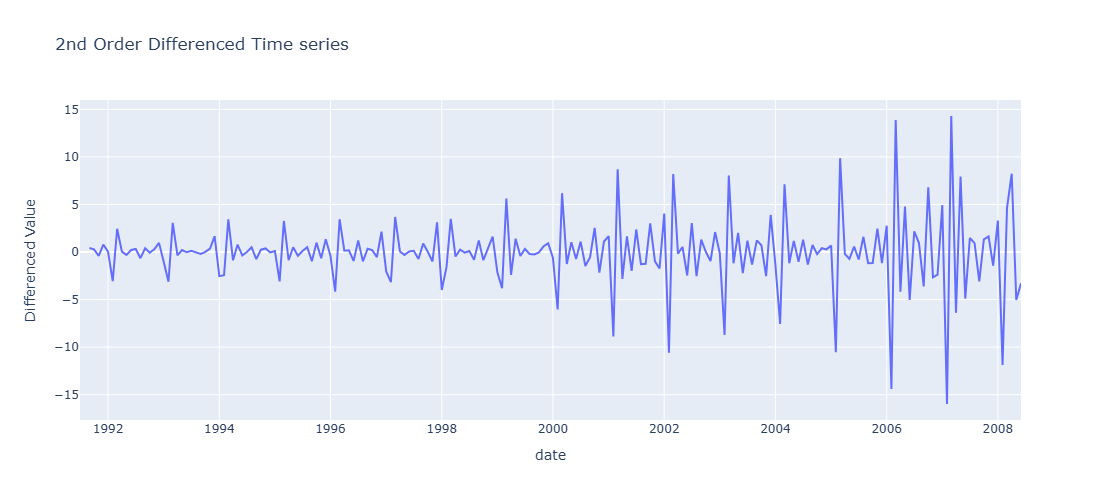

<Figure size 1000x500 with 0 Axes>

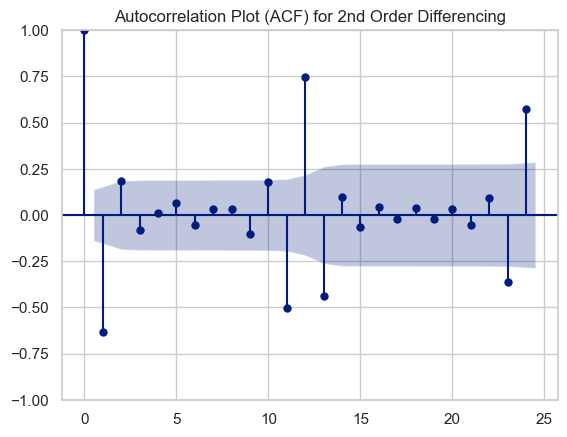

In [15]:
fig=px.line(x=df['date'],y=new_diff_2_data, title='2nd Order Differenced Time series')

fig.update_layout(width=1000,height=500, xaxis_title='date',yaxis_title='Differenced Value')
fig.show()


plt.figure(figsize=(10, 5))
plot_acf(new_diff_2_data.dropna())
plt.title('Autocorrelation Plot (ACF) for 2nd Order Differencing');



In [16]:
result = adfuller(new_diff_2_data.dropna(),autolag='AIC')
print('ADF Statistic: ', round(result[0],2))
print('p-value: ',round(result[1],3))

ADF Statistic:  -10.29
p-value:  0.0


* Since the p-value is 0.0, the time series is stationary.
* Now No need to apply differencing (i.e. d=0 in the ARIMA model).

### Finding the order of the AR term (p) for ARIMA model by plotting pacf plot

<Figure size 1000x700 with 0 Axes>

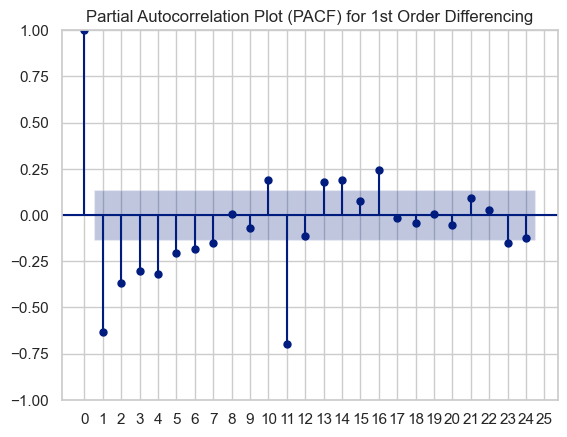

In [17]:
plt.figure(figsize=(10, 7))
plot_pacf(new_diff_2_data.dropna())
x_values = range(len(new_diff_2_data.dropna()))
plt.xticks(x_values[:26])
plt.title('Partial Autocorrelation Plot (PACF) for 1st Order Differencing');

**We can see that the PACF lag 1 is quite significant since it is first spike with well above the significance line(confidence interval bound). So, we will take the value of p as 1.**

### Now finding MA term (q) for ARIMA model by plotting acf plot

<Figure size 1000x500 with 0 Axes>

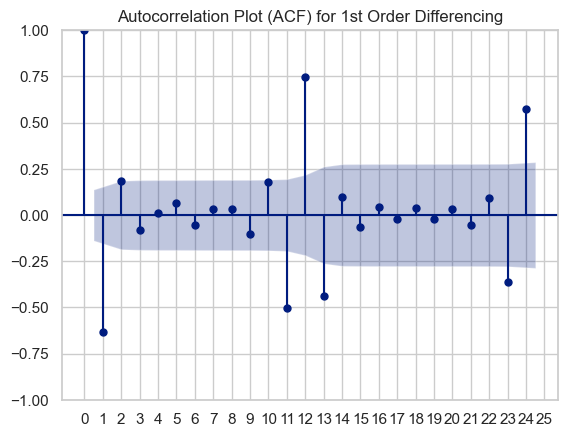

In [18]:
new_diff_1_data=df['value'].diff()

plt.figure(figsize=(10, 5))
plot_acf(new_diff_2_data.dropna())
x_values = range(len(new_diff_2_data.dropna()))
plt.xticks(x_values[:26])
plt.title('Autocorrelation Plot (ACF) for 1st Order Differencing');

**We can see significant spikes at lags 1, 11, and 24 which exceed the confidence interval bound so will choose the first significant lag where the autocorrelation cuts off So, we will fix q as 1.**

### Split the Data into Train and Test Sets

In [19]:
#converting difference data into dataframe
new_diff_2_data=pd.DataFrame(new_diff_2_data)
new_diff_2_data['date']=df['date']
new_diff_2_data.head()

value       date
0       NaN 1991-07-01
1       NaN 1991-08-01
2  0.417030 1991-09-01
3  0.287452 1991-10-01
4 -0.403916 1991-11-01

In [20]:
#droping nulls
new_diff_2_data=new_diff_2_data.dropna()
new_diff_2_data.head()

value       date
2  0.417030 1991-09-01
3  0.287452 1991-10-01
4 -0.403916 1991-11-01
5  0.785636 1991-12-01
6  0.041462 1992-01-01

In [21]:
to_row=int(len(new_diff_2_data)*0.8) #taking 80% of data for training

train=list(new_diff_2_data[0:to_row]['value'])
test=list(new_diff_2_data[to_row:]['value'])

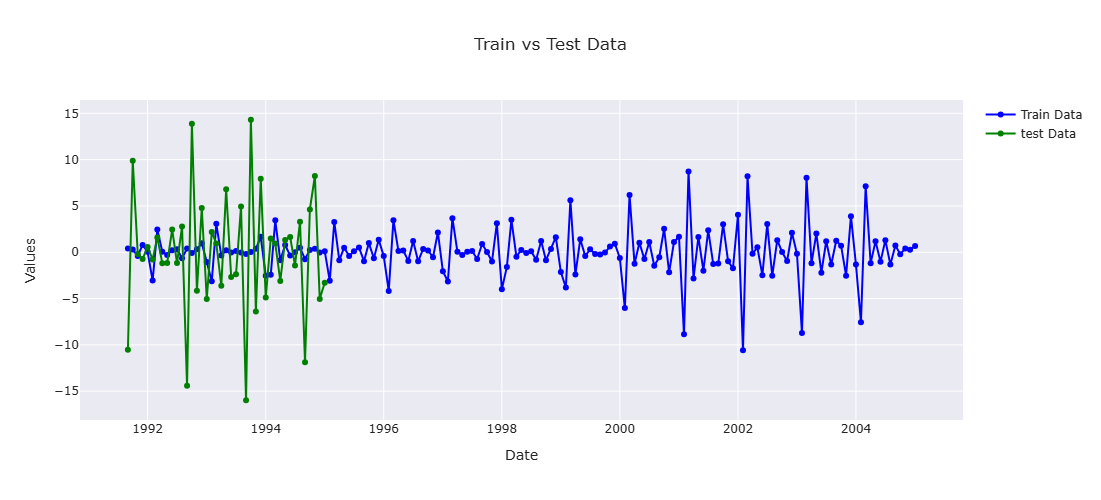

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=new_diff_2_data['date'],y=train, mode='lines+markers',name='Train Data',line=dict(color='blue')))

fig.add_trace(go.Scatter(x=new_diff_2_data['date'],y=test, mode='lines+markers',name='test Data',line=dict(color='green')))

fig.update_layout(width=1150,height=500,title='Train vs Test Data',xaxis_title='Date',yaxis_title='Values',template='seaborn')

fig.show()

### Building the ARIMA Model 

In [23]:
model=ARIMA(train,order=(1,0,1))
results_ARIMA=model.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  161
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -297.448
Date:                Mon, 06 Jan 2025   AIC                            602.896
Time:                        16:07:28   BIC                            615.221
Sample:                             0   HQIC                           607.900
                                - 161                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.486      0.627      -0.005       0.008
ar.L1         -0.3177      0.094     -3.379      0.001      -0.502      -0.133
ma.L1         -0.9998      6.533     -0.153      0.8

### Importance of SARIMAX Results Table

---
**Coef (Coefficient):** Shows how much each previous time step affects the current prediction.

**Std err (Standard Error):** Tells you how much the coefficient might change. Smaller values mean more confidence in the result.

**z (Z-statistic):** Measures how significant the coefficient is. Larger values are better.

**P-value:** Helps decide if the coefficient is important. If it's small (less than 0.05), the lag is important for the model. If it's large (more than 0.05), the lag might not be important.

**[0.025 0.975]:** Shows the range in which the coefficient could lie. If it includes 0, the coefficient might not be significant..

**`In short, P-value helps you know which lags matter for the model ,  A small p value means the lag is important while a large p-value suggests it might not be .`**

### Plot residual errors

In [24]:
residuals=pd.DataFrame({'residual values': results_ARIMA.resid})
residuals

residual values
0           0.415454
1           0.559608
2           0.022686
3           0.671454
4           0.811846
..               ...
156         0.517422
157         0.519564
158         0.849150
159         1.252765
160         2.009168

[161 rows x 1 columns]

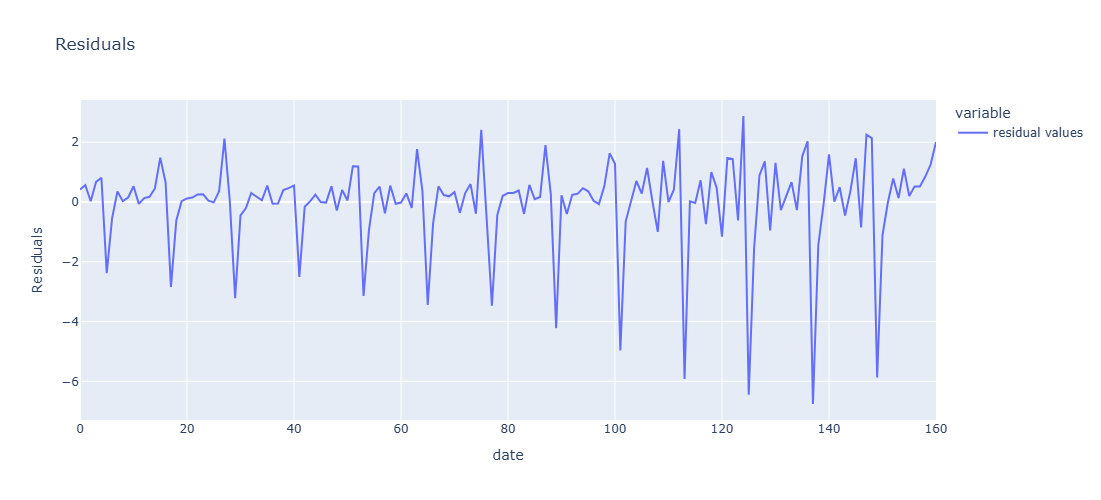

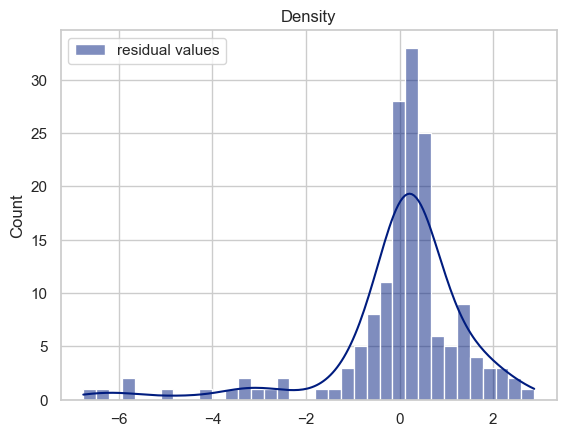

In [25]:
#sns.lineplot(data=residuals)

fig=px.line(residuals, title='Residuals')

fig.update_layout(width=1000,height=500, xaxis_title='date',yaxis_title='Residuals')
fig.show()

sns.histplot(data=residuals,kde=True)
plt.title('Density');

**The residual errors seem fine with near zero mean and uniform variance.**

In [26]:
new_diff_2_data["ARIMA_prediction"] = np.nan

arima_predictions = results_ARIMA.predict(start=len(train), end=len(train) + len(test) - 1)

new_diff_2_data.loc[len(train):len(train) + len(test) - 1, "ARIMA_prediction"] = arima_predictions
new_diff_2_data.head()


value       date  ARIMA_prediction
2  0.417030 1991-09-01               NaN
3  0.287452 1991-10-01               NaN
4 -0.403916 1991-11-01               NaN
5  0.785636 1991-12-01               NaN
6  0.041462 1992-01-01               NaN

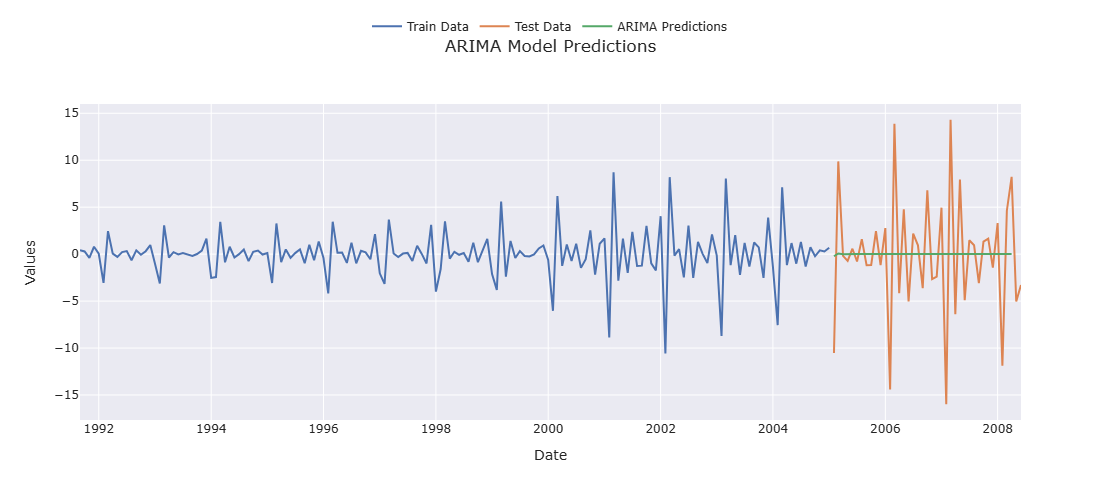

In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=new_diff_2_data['date'][:len(train)], y=new_diff_2_data["value"][:len(train)],mode='lines', name='Train Data'))

fig.add_trace(go.Scatter(x=new_diff_2_data['date'][len(train):len(train) + len(test)], y=new_diff_2_data["value"][len(train):],mode='lines', name='Test Data'))

fig.add_trace(go.Scatter(x=new_diff_2_data['date'][len(train):len(train) + len(test)], y=new_diff_2_data["ARIMA_prediction"][len(train):],mode='lines', name='ARIMA Predictions'))

fig.update_layout(width=1150,height=500,title="ARIMA Model Predictions",xaxis_title="Date",yaxis_title="Values", template="seaborn",legend=dict(
        orientation="h",
        yanchor="bottom", 
        y=1.2,           
        xanchor="center",
        x=0.5 ))

fig.show()


### Lets plot Actual values vs fitted values

In [28]:
fitted_values=results_ARIMA.fittedvalues
fitted_values

array([ 1.57569375e-03, -2.72155785e-01, -4.26602374e-01,  1.14181528e-01,
       -7.70384181e-01, -6.75810421e-01,  2.98785204e+00, -3.04293918e-01,
       -3.23722790e-01,  7.15263019e-02, -2.02364523e-01, -5.82008490e-01,
        2.66717568e-01, -2.45335400e-01, -1.37519628e-01, -5.21060480e-01,
       -1.69684099e+00, -2.83662338e-01,  3.68005926e+00, -3.85303773e-01,
        9.17010746e-02, -1.76307143e-01, -1.32265715e-01, -2.79619927e-01,
       -2.41545311e-01,  2.58891981e-02,  1.07177409e-02, -4.57615832e-01,
       -2.56890750e+00,  7.74301067e-01,  3.88854200e+00, -6.60506721e-01,
        4.83538300e-01, -5.38583538e-01, -5.65146913e-02, -5.54537496e-02,
       -6.85434700e-01,  2.95674188e-01, -2.42764409e-02, -5.06114199e-01,
       -4.38221073e-01, -5.73117074e-01,  3.42646150e+00, -8.79810134e-01,
        2.55436815e-01, -3.93412836e-01,  1.30015545e-01, -1.31795685e-02,
       -6.75718027e-01,  5.89654316e-01, -7.03760182e-01,  1.57691872e-01,
       -1.60290702e+00, -

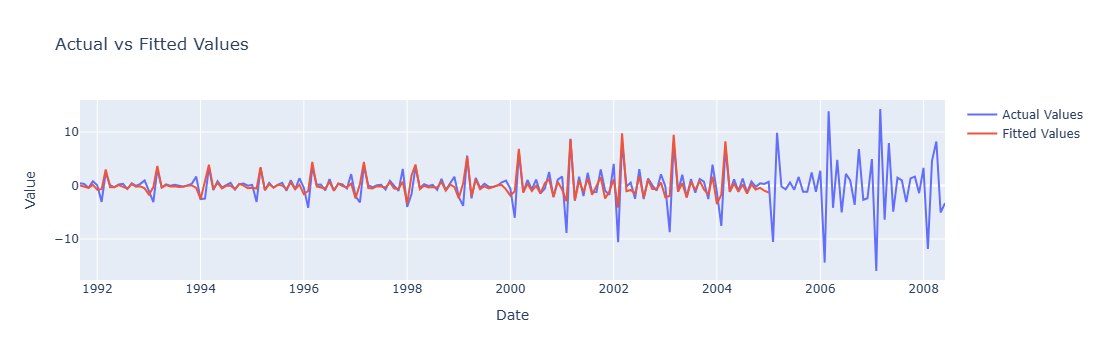

In [29]:

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(x=new_diff_2_data['date'],y=new_diff_2_data['value'],mode='lines',name='Actual Values'),row=1, col=1)

fig.add_trace(go.Scatter(x=new_diff_2_data['date'],y=results_ARIMA.fittedvalues,mode='lines',name='Fitted Values'),row=1, col=1)

fig.update_layout(title='Actual vs Fitted Values',xaxis_title='Date',yaxis_title='Value',showlegend=True)

fig.show()



1. **Actual Values:** These are the real observed data points from your dataset.

2. **Fitted Values:** These are the values that the model estimates based on the historical data. In other words, they are the values the model produces when fitting itself to the data points you already have. They help assess how well the model captures the underlying patterns of the data.

3. **Predicted Values:** These are the future data points that the model forecasts based on the patterns it identified in the historical data. The predicted values are used to make future projections and are typically beyond the time range of the actual values.

In summary:
- **Actual vs. Fitted Values:** This comparison helps you evaluate how well your model fits the historical data.
- **Actual vs. Predicted Values:** This comparison helps you evaluate the accuracy of your model's future forecasts.

While the fitted values and predicted values might seem similar, the key difference is that fitted values are within the historical data range, and predicted values are for future data points.


### Model Evaluation

In [31]:
from sklearn.metrics import mean_squared_error


error = np.sqrt(mean_squared_error(test, arima_predictions))
print('The RMSE value of the model: ',error)

The RMSE value of the model:  6.300100923233412
